In [1]:
%matplotlib inline
import json
import tensorflow as tf
import pandas as pd 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds


In [2]:
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


In [3]:
imdb, info = tfds.load("goemotions", with_info=True)
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/43410 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/goemotions/0.1.0.incompleteXQ5MIY/goemotions-train.tfrecord*...:   0%|        …

Generating validation examples...:   0%|          | 0/5426 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/goemotions/0.1.0.incompleteXQ5MIY/goemotions-validation.tfrecord*...:   0%|   …

Generating test examples...:   0%|          | 0/5427 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/goemotions/0.1.0.incompleteXQ5MIY/goemotions-test.tfrecord*...:   0%|         …

Dataset goemotions downloaded and prepared to ~/tensorflow_datasets/goemotions/0.1.0. Subsequent calls will reuse this data.
--2022-11-23 20:56:08--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.162.128, 74.125.31.128, 74.125.139.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.162.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  --.-KB/s    in 0.1s    

2022-11-23 20:56:08 (118 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

--2022-11-23 20:56:08--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.162.128, 74.125.31.128, 74.125.139.128, ...
Conn

In [4]:
train = pd.read_csv("https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv")
test = pd.read_csv("https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv")
validation = pd.read_csv("https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv")

In [6]:
def prepare(df) : 
  df = df.drop(['id','author','subreddit', 'link_id', 'parent_id', 'created_utc','rater_id','example_very_unclear'], axis = 1)
  return df

In [7]:
train =  prepare(train)

In [8]:
test = prepare(test)
validation = prepare(validation)

In [9]:
train['text'] = pd.Series(train['text'])
sentences_test = train['text']
labels_train = train.drop(['text'], axis = 1)

In [11]:
test['text'] = pd.Series(test['text'])
sentences_test = test['text']
labels_test = test.drop(['text'], axis = 1)

In [12]:
tokenizer = Tokenizer(num_words=len(train), oov_token=oov_tok)
tokenizer.fit_on_texts(train)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(sentences_test)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


testing_sequences = tokenizer.texts_to_sequences(sentences_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(labels_train)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(train), embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(28, activation='softmax')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           1120000   
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 28)                700       
                                                                 
Total params: 1,121,108
Trainable params: 1,121,108
Non-trainable params: 0
_________________________________________________________________


In [16]:
num_epochs = 4
history = model.fit(training_padded, labels_train, epochs=num_epochs, validation_data=(testing_padded, labels_test), verbose=2)

Epoch 1/4
2188/2188 - 47s - loss: 0.1795 - accuracy: 0.2435 - val_loss: 0.1574 - val_accuracy: 0.2608 - 47s/epoch - 21ms/step
Epoch 2/4
2188/2188 - 33s - loss: 0.1571 - accuracy: 0.2632 - val_loss: 0.1575 - val_accuracy: 0.2608 - 33s/epoch - 15ms/step
Epoch 3/4
2188/2188 - 31s - loss: 0.1571 - accuracy: 0.2632 - val_loss: 0.1576 - val_accuracy: 0.2608 - 31s/epoch - 14ms/step
Epoch 4/4
2188/2188 - 44s - loss: 0.1571 - accuracy: 0.2632 - val_loss: 0.1574 - val_accuracy: 0.2608 - 44s/epoch - 20ms/step


Let's try another way : 

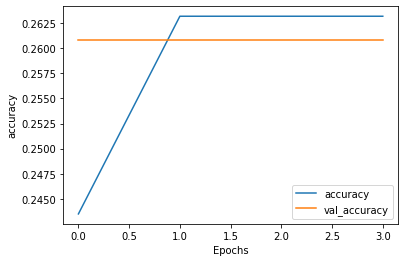

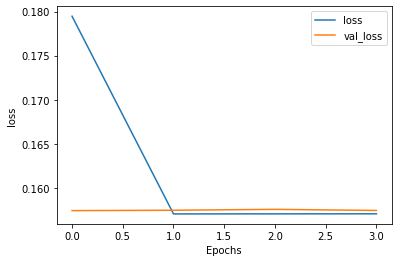

In [17]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")